* Gérer les adverbes
* comment mixer les features tf-idf et les autres, pour leur donner du poids? Lire des articles,
* faire deux modèles et mixer
* comment gérer l'ironie?
* Faire une fonction qui va uniquement prédire sur X derniers tweets de la collection tweet

In [12]:
import pymongo as pym
import nltk.data
import re
import string
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
import stop_words
from nltk.stem import *
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [6]:
stops = set(['rt','ds','qd','ss','ns','vs','nn','amp','gt','gd','gds','tt','pr','ac','mm', 'qu',
            '``', 'ni', 'ca', 'le', 'les', ' ', 'si', '$', '^', 'via', 'ils','pour','une','que','quel'] +
            list('@ن%£€‘:&;') + list('abcdefghijklmnopqrstuvwxyz')+
            stop_words.get_stop_words(language='fr')+stopwords.words('french'))
for e in ['ne','pas','sans','aucun'] :
    stops.remove(e)


In [36]:
def tweetPreprocessing(collection, nLastTweets=0, retweet=False):

    tweets = collection.find(filter={'text':{'$exists':True}}, 
                             projection={'_id':False}).sort('$natural',-1).limit(nLastTweets)  
    df = pd.DataFrame()
    listTweets, listCandidats, listSentiments = [], [], []

    for t in tweets: 
        if not retweet: # filtrage des retweets
            if 'rt @' in t['text']:
                continue
        # comptes
        a = t['text'].count('!')
        b = t['text'].count('?')
        c = t['text'].count('#')
        d = t['text'].count('"')
        e = t['text'].count('http')
        f = t['text'].count(':')
        g = t['text'].count('»')
        h = t['text'].count('@')
        
        # mot tronqué
        t['text'] = re.sub(r'\w*…', '', t['text'])
        
        # caracteres speciaux
        t['text'] = re.sub(r'\xad', '-',
                           re.sub(r'\n', ' ', # retrait des sauts de ligne
                                  re.sub(r'\[a-zA-Z]*(?!\S)', '', # retrait de ce qui n'est pas un mot
                                         re.sub(r'(?:htt)\S*', '', # retrait des liens http
                                                re.sub(r'^rt.*: ', '', # retrait de la mention retweet
                                                       re.sub(r'\d', '', # retrait des chiffres
                                                              re.sub(r',;!?\/\*(){}«»', ' ', t['text'])))))))
        
        t['text'] = re.sub('|'.join(['’', '_', '/', '-', '\'', '“', '\.']), ' ', t['text'])
        
        # accents (il faut laisser ce bloc)
#         t['text'] = re.sub('|'.join('Ééèêë'), 'e', t['text'])
#         t['text'] = re.sub('|'.join('àâä'), 'a', t['text'])
#         t['text'] = re.sub('|'.join('ç'), 'c', t['text'])
#         t['text'] = re.sub('|'.join('œ'), 'oe', t['text'])
#         t['text'] = re.sub('|'.join('Ôôö'), 'o', t['text'])
#         t['text'] = re.sub('|'.join('îï'), 'i', t['text'])
#         t['text'] = re.sub('|'.join('ùû'), 'u', t['text'])
        
        # apostrophes
        t['text'] = re.sub('|'.join([elem + '\'' for elem in 'cdjlmnst']), '', t['text'])
        
        tokenizer = TreebankWordTokenizer()
        t['text'] = tokenizer.tokenize(t['text'])
        t['text'] = [token for token in t['text'] if (token not in stops) and (len(token)>2)]
        negation = 0
        adverbes = 0
        for token in t['text'] : 
            if token in ['ne','pas','n\'','n','sans','aucun','nul','nulle','rien','jamais','personne'] : 
                negation += 1
            if re.match('\w\S*ment', token) is not None :
                adverbes += 1
                
        while '' in t['text']:
            t['text'].pop('')
            
        if t['text']: # test si liste non vide
            listTweets.append(t['text'])
            try:
                listCandidats.append(t['candidat'])
            except:
                listCandidats.append(None)
            
            try:
                listSentiments.append(t['sentiment'])
            except:
                listSentiments.append(None)
                
            rec = pd.DataFrame([[a, b, c, d, e, f,g, h, negation, adverbes]], 
                               columns=['!', '?', '#', '"', '_http_',':','»','@','négation','adverbes'])
            df = df.append(rec, ignore_index=True)
        
    df['text'], df['candidat'], df['sentiment'] = listTweets, listCandidats, listSentiments
    return df

def build_feat_mat(df_tweets):
    vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', decode_error='strict',
                                use_idf=True, norm='l2', binary=False, min_df=0.001, max_df=0.5, ngram_range=(1,2))
    tfidf = vectorizer.fit_transform(df_tweets['text'].apply(' '.join))
    X = pd.DataFrame(tfidf.toarray())
    X[['!', '?', '#', '"', '_http_',':','»','@','négation','adverbes']] = \
    df_tweets[['!', '?', '#', '"', '_http_',':','»','@','négation','adverbes']]
    return X


def getSentiments(client, retweet, classifier, full_retrain=True ) : 
    if full_retrain :
        # bases utilisées
        df = tweetPreprocessing(client.tweet.train, 0, retweet)
        df2 = tweetPreprocessing(client.tweet.labelised, 0, retweet)
        try:
            df = pd.concat([df, df2], axis=0, ignore_index=True)
        except:
            pass
        df = df.sample(frac=1.0, replace=False) # mélange des lignes
        X = build_feat_mat(df)
        y = df['sentiment']
        X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
        n_samples, vocabulaire = X.shape
        print('Tweets : ' + str(n_samples) + ' / ' + 'Mots : ' + str(vocabulaire))
        if classifier == 'lr':
            params = {'penalty':['l2'], 'C' : np.logspace(-1,2,10), 'multi_class':['ovr','multinomial']}
            clf = LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced')
            
        if classifier == 'svc':
            params = {'C' : np.linspace(0.3, 0.6, 5)}
            clf = SVC(class_weight='balanced', max_iter=2000, kernel='linear', decision_function_shape='ovr')
            
        GCV = GridSearchCV(clf, params, verbose=9, n_jobs=-1)
        GCV.fit(X_train, y_train)
        print(GCV.best_params_)
        if classifier == 'lr' :
            model = LogisticRegression(penalty=GCV.best_params_['penalty'],
                                   C=GCV.best_params_['C'],
                                       multi_class=GCV.best_params_['multi_class'], class_weight='balanced')
        if classifier == 'svc' :
            model = SVC(C=GCV.best_params_['C'], gamma=1e-15,
                        decision_function_shape='ovr')
    
    else :
        f = open('sentiment_model.pkl','rb')
        model = pickle.load(f)
        f.close()
        # bases utilisées
        df = tweetPreprocessing(client.tweet.train, 500, retweet)
        df2 = tweetPreprocessing(client.tweet.labelised, 500, retweet)
        try:
            df = pd.concat([df, df2], axis=0, ignore_index=True)
        except:
            pass
        df = df.sample(frac=1.0, replace=False) # mélange des lignes
        X = build_feat_mat(df)
        y = df['sentiment']
        n_samples, vocabulaire = X.shape
        print('Tweets : ' + str(n_samples) + ' / ' + 'Mots : ' + str(vocabulaire))

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print('Score', np.sum(predictions == y_test) / len(predictions)) 
    f = open('sentiment_model.pkl','wb')
    pickle.dump(model, f)
    f.close()
    print('Model saved')
    return predictions

def cleanTrainDb(collection):
    textCleanPipeline = [{"$group":{"_id":"$text", "dups":{"$push":"$_id"},"count":{"$sum":1}}},{"$match":{"count":{"$gt":1}}}]
    duplicates = []
    count = 0
    try:
        for doc in collection.aggregate(textCleanPipeline) :
            it = iter(doc['dups'])
            next(it)
            for id in it:
                count += 1
                duplicates.append(pym.DeleteOne({'_id':id}))
        if duplicates:
            collection.bulk_write(duplicates)
    except:
        pass
    
    print(count, 'doublons retirés.')
    client.close()

In [34]:
client = pym.MongoClient('localhost', 27018)
#client = pym.MongoClient('localhost', 27017)
collection = client.tweet.train
collection2 = client.tweet.labelised
print(collection.count())
print(collection2.count())

8003
1421


### Test du nettoyage des tweets

In [68]:
a = tweetPreprocessing(collection, retweet=True)

### Test du nettoyage doublons

In [29]:
cleanTrainDb(collection)
cleanTrainDb(collection2)

0 doublons retirés.
0 doublons retirés.


## Train et test du modèle

In [38]:
a = getSentiments(client, retweet=True, classifier='lr', full_retrain=True)
# attention en cas de retrain périodique on ne prend que les 500 derniers tweets, il faut donc prédire sur moins de 500
#print(len(a[a==1]), len(a[a==0]))
b = getSentiments(client, retweet=True, classifier='svc', full_retrain=True)
print(len(b[b==1]), len(b[b==0]))


Tweets : 9390 / Mots : 1452
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] multi_class=ovr, C=0.1, penalty=l2 ..............................
[CV] multi_class=ovr, C=0.1, penalty=l2 ..............................
[CV] multi_class=ovr, C=0.1, penalty=l2 ..............................
[CV]  multi_class=ovr, C=0.1, penalty=l2, score=0.547543, total=   3.1s
[CV] multi_class=multinomial, C=0.1, penalty=l2 ......................
[CV]  multi_class=ovr, C=0.1, penalty=l2, score=0.554348, total=   3.1s


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s


[CV] multi_class=multinomial, C=0.1, penalty=l2 ......................
[CV]  multi_class=ovr, C=0.1, penalty=l2, score=0.551151, total=   3.4s
[CV] multi_class=multinomial, C=0.1, penalty=l2 ......................
[CV]  multi_class=multinomial, C=0.1, penalty=l2, score=0.562859, total=   3.7s
[CV] multi_class=ovr, C=0.215443469003, penalty=l2 ...................
[CV]  multi_class=multinomial, C=0.1, penalty=l2, score=0.557545, total=   3.4s
[CV] multi_class=ovr, C=0.215443469003, penalty=l2 ...................
[CV]  multi_class=multinomial, C=0.1, penalty=l2, score=0.551790, total=   4.1s
[CV] multi_class=ovr, C=0.215443469003, penalty=l2 ...................
[CV]  multi_class=ovr, C=0.215443469003, penalty=l2, score=0.574984, total=   4.7s
[CV] multi_class=multinomial, C=0.215443469003, penalty=l2 ...........
[CV]  multi_class=ovr, C=0.215443469003, penalty=l2, score=0.573529, total=   4.5s
[CV] multi_class=multinomial, C=0.215443469003, penalty=l2 ...........
[CV]  multi_class=ovr, C=

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   18.6s


[CV]  multi_class=ovr, C=0.464158883361, penalty=l2, score=0.578813, total=   6.0s
[CV] multi_class=multinomial, C=0.464158883361, penalty=l2 ...........
[CV]  multi_class=ovr, C=0.464158883361, penalty=l2, score=0.577366, total=   6.4s
[CV] multi_class=multinomial, C=0.464158883361, penalty=l2 ...........
[CV]  multi_class=ovr, C=0.464158883361, penalty=l2, score=0.581202, total=   6.4s
[CV] multi_class=multinomial, C=0.464158883361, penalty=l2 ...........
[CV]  multi_class=multinomial, C=0.464158883361, penalty=l2, score=0.573708, total=   7.3s
[CV] multi_class=ovr, C=1.0, penalty=l2 ..............................
[CV]  multi_class=multinomial, C=0.464158883361, penalty=l2, score=0.573529, total=   7.0s
[CV] multi_class=ovr, C=1.0, penalty=l2 ..............................
[CV]  multi_class=multinomial, C=0.464158883361, penalty=l2, score=0.576726, total=   6.0s
[CV] multi_class=ovr, C=1.0, penalty=l2 ..............................
[CV]  multi_class=ovr, C=1.0, penalty=l2, score=0.56

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min


[CV]  multi_class=ovr, C=2.15443469003, penalty=l2, score=0.574808, total=  12.2s
[CV] multi_class=multinomial, C=2.15443469003, penalty=l2 ............
[CV]  multi_class=multinomial, C=2.15443469003, penalty=l2, score=0.556477, total=  14.6s
[CV] multi_class=ovr, C=4.64158883361, penalty=l2 ....................
[CV]  multi_class=multinomial, C=2.15443469003, penalty=l2, score=0.554987, total=  13.8s
[CV] multi_class=ovr, C=4.64158883361, penalty=l2 ....................
[CV]  multi_class=multinomial, C=2.15443469003, penalty=l2, score=0.567136, total=  14.1s
[CV] multi_class=ovr, C=4.64158883361, penalty=l2 ....................
[CV]  multi_class=ovr, C=4.64158883361, penalty=l2, score=0.552010, total=  16.4s
[CV] multi_class=multinomial, C=4.64158883361, penalty=l2 ............
[CV]  multi_class=ovr, C=4.64158883361, penalty=l2, score=0.563299, total=  15.7s
[CV] multi_class=multinomial, C=4.64158883361, penalty=l2 ............
[CV]  multi_class=ovr, C=4.64158883361, penalty=l2, score=

[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  3.2min


[CV]  multi_class=ovr, C=21.5443469003, penalty=l2, score=0.537084, total=  29.4s
[CV] multi_class=multinomial, C=21.5443469003, penalty=l2 ............
[CV]  multi_class=multinomial, C=21.5443469003, penalty=l2, score=0.537971, total=  32.1s
[CV] multi_class=ovr, C=46.4158883361, penalty=l2 ....................
[CV]  multi_class=multinomial, C=21.5443469003, penalty=l2, score=0.539642, total=  32.4s
[CV] multi_class=ovr, C=46.4158883361, penalty=l2 ....................
[CV]  multi_class=multinomial, C=21.5443469003, penalty=l2, score=0.529412, total=  35.4s
[CV] multi_class=ovr, C=46.4158883361, penalty=l2 ....................
[CV]  multi_class=ovr, C=46.4158883361, penalty=l2, score=0.535418, total=  40.8s
[CV] multi_class=multinomial, C=46.4158883361, penalty=l2 ............
[CV]  multi_class=ovr, C=46.4158883361, penalty=l2, score=0.543478, total=  40.3s
[CV] multi_class=multinomial, C=46.4158883361, penalty=l2 ............
[CV]  multi_class=ovr, C=46.4158883361, penalty=l2, score=

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.8min finished


{'multi_class': 'ovr', 'penalty': 'l2', 'C': 0.46415888336127786}
Score 0.597444089457
Model saved
Tweets : 9390 / Mots : 1452
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.3 ...........................................................
[CV] C=0.3 ...........................................................
[CV] C=0.3 ...........................................................
[CV] ............................ C=0.3, score=0.593610, total=  50.0s
[CV] C=0.375 .........................................................
[CV] ............................ C=0.3, score=0.583014, total=  50.1s
[CV] C=0.375 .........................................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min


[CV] ............................ C=0.3, score=0.599105, total=  51.9s
[CV] C=0.375 .........................................................
[CV] .......................... C=0.375, score=0.588761, total=  48.8s
[CV] C=0.45 ..........................................................
[CV] .......................... C=0.375, score=0.598722, total=  50.1s
[CV] C=0.45 ..........................................................
[CV] .......................... C=0.375, score=0.592072, total=  51.2s
[CV] C=0.45 ..........................................................
[CV] ........................... C=0.45, score=0.579821, total=  48.7s
[CV] C=0.525 .........................................................
[CV] ........................... C=0.45, score=0.594888, total=  48.7s
[CV] C=0.525 .........................................................
[CV] ........................... C=0.45, score=0.584399, total=  50.1s
[CV] C=0.525 .........................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  5.2min remaining:  1.3min


[CV] ............................ C=0.6, score=0.577905, total=  46.4s
[CV] ............................ C=0.6, score=0.586581, total=  47.3s
[CV] ............................ C=0.6, score=0.574169, total=  48.0s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.5min finished


{'C': 0.375}
Score 0.462619808307
Model saved
0 0


# Essai sur un Xgboost

In [46]:


def TrainXGBoostModel(client, retweet=True, gpuEnabled=False):
    df = tweetPreprocessing(client.tweet.train, 0, retweet)
    df2 = tweetPreprocessing(client.tweet.labelised, 0, retweet)
    try:
        df = pd.concat([df, df2], axis=0, ignore_index=True)
    except:
        pass
    df = df.sample(frac=1.0, replace=False) # mélange des lignes
    X = build_feat_mat(df)
    df[df['sentiment'] == -1] = 2
    y = df['sentiment']
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1) # 10 % for validation
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1) # 10 % for test
    n_samples, vocabulaire = X.shape
    print('Tweets : ' + str(n_samples) + ' / ' + 'Mots : ' + str(vocabulaire))

    boostRounds = 10
    # XGBoost data structure
    xgtrain = xgb.DMatrix(x_train.values, y_train.values)
    xgeval = xgb.DMatrix(x_val.values, y_val.values)
    xgtest = xgb.DMatrix(x_test.values)
    params = {'eta': 0.01, 'gamma' : 0.2, 'max_depth': 200, 'num_class':3,
              'lambda': 3, 'alpha': 0.05, 'objective':'multi:softmax', 'eval_metric':'merror', 'eval_metric':'merror'}
     
    
    # Generate the watchlist
    watchlist = [(xgtrain, "train"), (xgeval, "eval")]
    print("Train the XGBoost model...")
    startTime = time.time()
    clf = xgb.train(params, xgtrain, boostRounds, evals = watchlist, 
                    maximize = True, verbose_eval = 100)

    #Make predictions
    print("Make predictions for testing set...")
    predictions_sr = pd.Series(clf.predict(xgtest, ntree_limit = clf.best_iteration))
    return predictions_sr, clf, y_test, x_train.



In [56]:
preds, model,  truth = TrainXGBoostModel(client)

Tweets : 7791 / Mots : 13133
Train the XGBoost model...
[0]	train-merror:0.183864	eval-merror:0.423077
Make predictions for testing set...


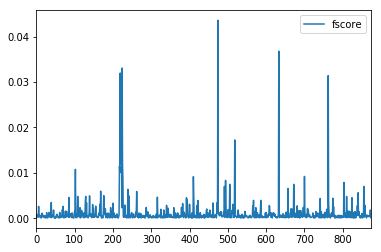

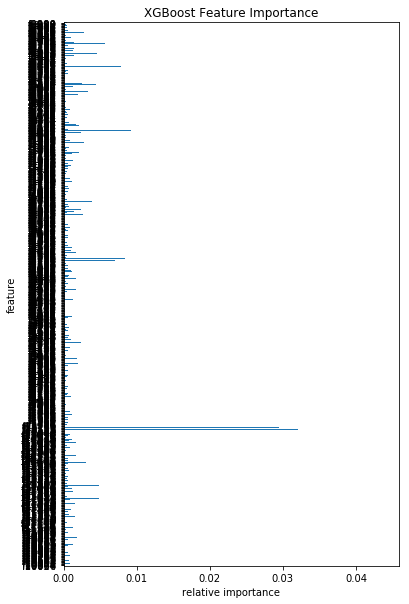

In [79]:
importance = model.get_fscore()
importance = sorted(importance.items())
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [ ]:
print()

In [51]:
print(model.)
print('Score', np.sum(truth  == preds) / len(preds)) 

Score index        0.0
sentiment    0.0
0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
5            0.0
6            0.0
7            0.0
8            0.0
9            0.0
10           0.0
11           0.0
12           0.0
13           0.0
14           0.0
15           0.0
16           0.0
17           0.0
18           0.0
19           0.0
20           0.0
21           0.0
22           0.0
23           0.0
24           0.0
25           0.0
26           0.0
27           0.0
            ... 
672          0.0
673          0.0
674          0.0
675          0.0
676          0.0
677          0.0
678          0.0
679          0.0
680          0.0
681          0.0
682          0.0
683          0.0
684          0.0
685          0.0
686          0.0
687          0.0
688          0.0
689          0.0
690          0.0
691          0.0
692          0.0
693          0.0
694          0.0
695          0.0
696          0.0
697          0.0
698          0.0
699     